<a href="https://colab.research.google.com/github/JanakiRaman-2002/tensorflow/blob/main/LipNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install & Import dependencies

In [ ]:
!pip list

In [2]:
  !pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

##Building Data Loading Function

In [5]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [10]:
def load_video(path:str) -> List[float]:

  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236, 80:220, :])
  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames-mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The Vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The Vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [13]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [14]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [15]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [32]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # print("PATH",path)
    file_name = path.split('/')[-1].split('.')[0]
    # print("FILE NAME",file_name)
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    # print("VIDEO PATH",video_path)
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # print("ALIGNMENTS PATH",alignment_path)
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [17]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [23]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [24]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

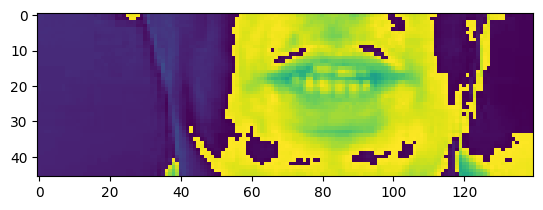

In [25]:
plt.imshow(frames[40])

In [26]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [27]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [34]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
result = mappable_function(test_path)
result

##Create Data Pipeline

In [87]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [88]:
frames, alignments = data.as_numpy_iterator().next()

In [90]:
frames[10]

IndexError: index 10 is out of bounds for axis 0 with size 2

In [38]:
plt.imshow(frames[10])

IndexError: index 10 is out of bounds for axis 0 with size 2

In [39]:
len(frames)

2

In [40]:
alignments

array([[12,  1, 25, 39,  2, 12, 21,  5, 39,  2, 25, 39, 18, 39, 26,  5,
        18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39, 12, 39, 20,
        23, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [41]:
test = data.as_numpy_iterator()

In [ ]:
val = test.next(); val[0]

In [43]:
val[0][1].shape

(75, 46, 140, 1)

In [44]:
type(val[0][1])

numpy.ndarray

In [45]:
random_array = val[0][1].astype(np.uint8)

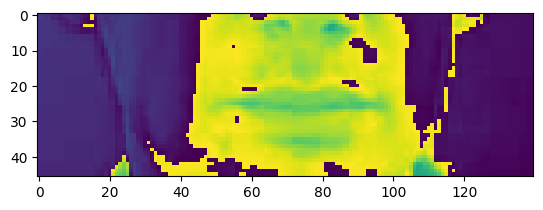

In [46]:
plt.imshow(val[0][0][0])

In [47]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white by l seven soon'>

##Design Deep Neural Network

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [72]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [73]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [75]:
yhat = model.predict(val[0])

1/1 [==============================] - 1s 1s/step


In [76]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff'>

In [54]:
model.input_shape

(None, 75, 46, 140, 1)

In [55]:
model.output_shape

(None, 75, 41)

##Setup Training Options and Training

In [56]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [77]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [78]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [79]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [80]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [81]:
schedule_callback = LearningRateScheduler(scheduler)

In [82]:
example_callback = ProduceExample(test)

AttributeError: 'NumpyIterator' object has no attribute 'as_numpy_iterator'

In [83]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback])

KeyboardInterrupt: 

#Preds

In [84]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=3658c6cd-36e5-4970-b1ba-d8c424ef7dff
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 120MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [85]:
model.load_weights('models/checkpoint')

In [91]:
test_data = test.as_numpy_iterator()

In [92]:
sample = test_data.next()

In [93]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [94]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h two please'>]

In [95]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [96]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at h two please'>]